# Coursework 1 - Supervised learning - Task 2

# Outline

- [Task 2](#task-2): Classification <a name="index-task-2"></a>
  - [(2.1)](#task-21) k-Nearest Neighbours <a name="index-task-21"></a>
    - [(2.1.1)](#task-211)  <a name="index-task-211"></a>
    - [(2.1.2)](#task-212) <a name="index-task-212"></a>
    - [(2.1.3)](#task-213) <a name="index-task-213"></a>
  - [(2.2)](#task-22) Logistic regression vs kernel logistic regression <a name="index-task-22"></a>
    - [(2.2.1)](#task-221) <a name="index-task-221"></a>
    - [(2.2.2)](#task-222) <a name="index-task-222"></a>
    - [(2.2.3)](#task-223) <a name="index-task-223"></a>

In [1]:
# Importing standard packages in alphabetical order
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Changing default font sizes
plt.rc('xtick', labelsize=16) # Tick labels
plt.rc('ytick', labelsize=16) # Tick labels
plt.rc('legend', fontsize=14) # Legend
plt.rc('axes', titlesize=24, labelsize=20) # Title and 'x' and 'y' labels

rng = np.random.default_rng(0)

I first load the dataset, which is a dataset designed for the diagnosis of brain cancer via the solution of a classification task.

In [2]:
# Reading .csv files
df_train = pd.read_csv('brain_cancer_samples.csv')
df_test = pd.read_csv('brain_cancer_test.csv')

# Printing full training DataFrame
df_train

,Patient ID,2D Surface,Contour Size,Total Surface,Density,Diameter,Primary Axis,Shape Variation,Location,Eccentricity_Real,Eccentricity_Imag,Class
0,1,1325.5,160.124890,1518.5,0.872901,41.081371,36.290924,53.992371,2,6.750000e-17,1.101565,1
1,2,81.5,39.556349,88.0,0.926136,10.186708,8.801125,15.591203,2,8.950000e-17,1.462264,1
2,3,57177.0,912.607209,57611.0,0.992467,269.814784,234.644165,312.589264,4,5.390000e-17,0.880179,0
3,4,135.0,92.083260,206.0,0.655340,13.110581,6.568726,40.183521,3,3.700000e-16,6.035112,0
4,5,6653.0,1525.307779,84025.5,0.079178,92.037290,383.980133,402.407623,3,1.920000e-17,0.313504,1
...,...,...,...,...,...,...,...,...,...,...,...,...
140,141,61.5,31.899495,65.5,0.938931,8.848968,9.686973,12.779761,4,5.270000e-17,0.860512,0
141,142,1933.0,171.681239,1972.5,0.979975,49.610201,43.783520,57.397675,1,5.190000e-17,0.847685,1
142,143,1187.0,581.455844,1959.0,0.605921,38.875897,9.854265,277.515595,0,1.720000e-15,28.144217,1
143,144,8056.0,640.724959,13503.5,0.596586,101.277923,81.612198,212.267380,1,1.470000e-16,2.401004,1


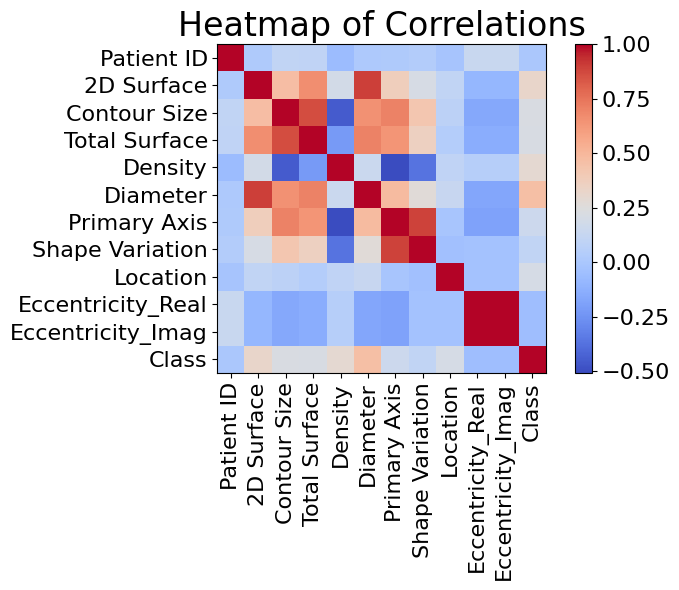

In [13]:
corr_matrix = df_train.corr()

# Plotting the heatmap using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.title('Heatmap of Correlations')
plt.tight_layout()
plt.show()

The column "Patient ID" with integer values does not contain a feature predictive of the outcome, it is just an ID for the samples, and hence it should not be used in prediction.

In [ ]:
df_train = df_train.drop(['Patient ID'],axis=1)
df_test = df_test.drop(['Patient ID'],axis=1)

In [ ]:
# Excluding patient ID and class
X_train = df_train.iloc[:, 0:-1].values
X_test = df_test.iloc[:, 0:-1].values

# class labels (y)
y_train = np.array(df_train['Class'].values).astype(int)
y_test = np.array(df_test['Class'].values).astype(int)

In [ ]:
# shuffling the rows in X and y
perm_ind_train = rng.permutation(len(y_train))
X_train = X_train[perm_ind_train]
y_train = y_train[perm_ind_train]

perm_ind_test= rng.permutation(len(y_test))
X_test = X_test[perm_ind_test]
y_test = y_test[perm_ind_test]

<a name="task-21"></a>

## (2.1) k-Nearest Neighbours [(index)](#index-task-21)

As we learned, standardisation is crucial for kNN as it is a distance-based method. Here I implement the standardisation on training and test sets with the statistics from the training set.

In [ ]:
def standardise(X, X_train_=None):
    """Standardise features.

    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.

    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0, keepdims=True)
    sigma = np.std(X_train_, axis=0, keepdims=True)
    X_std = (X - mu) / sigma
    return X_std

In [ ]:
# standardise train and test data
X_test_std = standardise(X_test, X_train_=X_train)
X_train_std = standardise(X_train)

I also load other functions from the kNN notebook (for classification) here.

In [ ]:
def euclidean_distance(x_i, x_j):

    '''
    Argument:
    x_i: vector with shape (p,)
    x_j: matrix with shape (n, p)

    Returns:
    d: distance between x_i and each row of x_j
    '''

    assert x_j.shape[1] == x_i.shape[0]

    return np.sqrt(np.sum((x_i-x_j)**2, axis=1))

In [ ]:
def k_neighbours(X_train, X_test, k=5, return_distance=False):
  """
  This function finds the k nearest neighbours in X_train for each point in X_test .

  Argument:
  X_train: training data
  X_test: test data
  k: number of nearest neighbours
  return_distance: if True, return distances too

  Returns:
  np.array(neigh_ind): array of indices of k nearest neighbours

  """

  n_neighbours = k
  dist = []
  neigh_ind = []

  # compute distance from each point x_test in X_test to all points in X_train (hint: use python's list comprehension)
  point_dist = [euclidean_distance(x_test, X_train) for x_test in X_test]

  # determine which k training points are closest to each test point
  for row in point_dist:
      enum_neigh = enumerate(row)
      sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

      ind_list = [tup[0] for tup in sorted_neigh]
      dist_list = [tup[1] for tup in sorted_neigh]

      dist.append(dist_list)
      neigh_ind.append(ind_list)

  # return distances together with indices of k nearest neighbours
  if return_distance:
      return np.array(dist), np.array(neigh_ind)

  return np.array(neigh_ind)

In [ ]:
def predict(X_train, y_train, X_test, k=5):
  """
  This function predicts labels of test data given training data and labels.

  Argument:
  X_train: training data
  y_train: training labels
  X_test: test data
  k: number of nearest neighbours

  Returns:
  y_pred: predicted labels for X_test

  """
  # each of the k neighbours contributes equally to the classification of any data point in X_test
  neighbours = k_neighbours(X_train, X_test, k=k)
  # count number of occurences of label with np.bincount and choose the label that has most with np.argmax (hint: use python's list comprehension)
  y_pred = np.array([np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours]) ## <-- SOLUTION

  return y_pred

In [ ]:
def score(X_train, y_train, X_test, y_test, k=5):

  y_pred = predict(X_train, y_train, X_test, k=k)

  return float(sum(y_pred==y_test))/ float(len(y_test))

In [ ]:
def cross_validation_score(X_train, y_train, folds, k):
  scores = []
  for i in range(len(folds)):
    val_indexes = folds[i]
    train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))

    X_train_i = X_train[train_indexes, :]
    y_train_i = y_train[train_indexes]

    X_val_i = X_train[val_indexes, :]
    y_val_i = y_train[val_indexes]

    score_i = score(X_train_i, y_train_i, X_val_i, y_val_i, k=k)
    scores.append(score_i)

  # Return the average score
  return sum(scores) / len(scores)

In [ ]:
def choose_best_k(X_train, y_train, folds, k_range):
  k_scores = np.zeros((len(k_range),))

  for i, k in enumerate(k_range):
    k_scores[i] = cross_validation_score(X_train, y_train, folds, k)
    print(f'CV_ACC@k={k}: {k_scores[i]:.3f}')

  best_k_index = np.argmax(k_scores)
  return k_scores, k_range[best_k_index]

<a name="task-211"></a>

### (2.1.1) [(index)](#index-task-211)

In this subtask, we implement ordinary kNN and use 5-fold cross validation to find the best k. The micro-averaged accuracy is already the metric used in the functions from the notebook given.

In [ ]:
# Now we have a list of five index arrays, each correspond to one of the five folds.
n_fold = 5
folds_indexes = np.split(np.arange(len(y_train)), n_fold)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
        46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]),
 array([58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
        75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]),
 array([ 87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115]),
 array([116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144])]

In [ ]:
k_scores, best_k = choose_best_k(X_train_std, y_train, folds_indexes, np.arange(1, 26))

print('best_k:', best_k)

CV_ACC@k=1: 0.628
CV_ACC@k=2: 0.655
CV_ACC@k=3: 0.724
CV_ACC@k=4: 0.676
CV_ACC@k=5: 0.710
CV_ACC@k=6: 0.703
CV_ACC@k=7: 0.738
CV_ACC@k=8: 0.738
CV_ACC@k=9: 0.724
CV_ACC@k=10: 0.697
CV_ACC@k=11: 0.697
CV_ACC@k=12: 0.683
CV_ACC@k=13: 0.662
CV_ACC@k=14: 0.655
CV_ACC@k=15: 0.669
CV_ACC@k=16: 0.655
CV_ACC@k=17: 0.662
CV_ACC@k=18: 0.641
CV_ACC@k=19: 0.607
CV_ACC@k=20: 0.621
CV_ACC@k=21: 0.593
CV_ACC@k=22: 0.600
CV_ACC@k=23: 0.621
CV_ACC@k=24: 0.614
CV_ACC@k=25: 0.586
best_k: 7


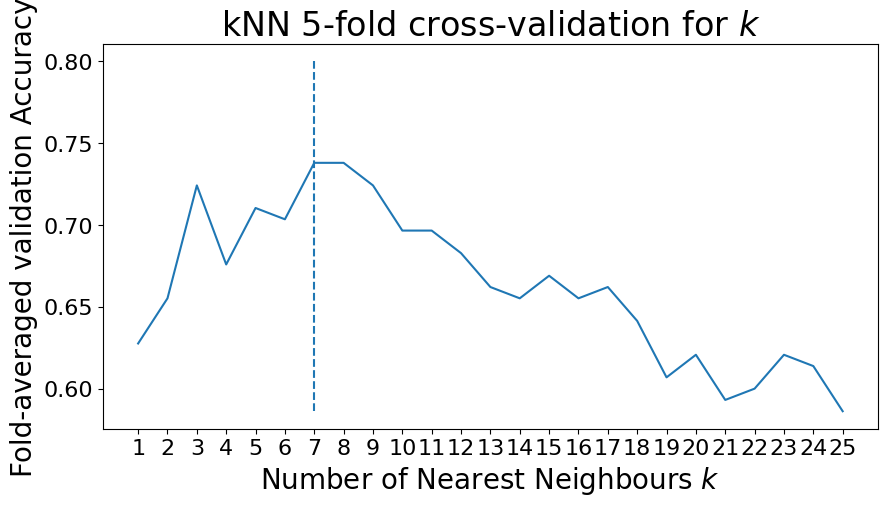

In [ ]:
#Plot the cross-validation scores as a function of k

plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 26), k_scores)
plt.xlabel(r'Number of Nearest Neighbours $k$')
plt.ylabel(r'Fold-averaged validation Accuracy')
plt.vlines(x=best_k, ymin=min(k_scores), ymax=0.8, linestyles='dashed')
plt.xticks(np.arange(1, 26))
plt.title(r"kNN 5-fold cross-validation for $k$")
plt.show()

One observes that over the chosen range of k (1,...,25), the accuracy hits a optimal value at 7 and then decreases as k increases. Hence we consider the range is sufficiently wide and no larger values of k need to be tested. I next re-train the model with this optimal k, and I check the training and test (micro-averaged) accuracy obtained.

In [ ]:
k = best_k
print('Training set mean accuracy:', score(X_train_std, y_train, X_train_std, y_train, k=k))
print('Test set mean accuracy:', score(X_train_std, y_train, X_test_std, y_test, k=k))

Training set mean accuracy: 0.7931034482758621
Test set mean accuracy: 0.6666666666666666


I see that even after training on the whole training data, the accuracies are not very close to one. As suggested in the question, this might be caused by the presence of minority class (namely, a class which appears less frequently and therefore harder to predict).

In [ ]:
classes_train, counts_train = np.unique(y_train, return_counts=True)
for i in range(3):
  print(f'Class {classes_train[i]}: {counts_train[i]} samples')

Class 0: 47 samples
Class 1: 80 samples
Class 2: 18 samples


In [ ]:
classes_test, counts_test = np.unique(y_test, return_counts=True)
for i in range(3):
  print(f'Class {classes_test[i]}: {counts_test[i]} samples')

Class 0: 18 samples
Class 1: 35 samples
Class 2: 7 samples


Clearly, Class 2 is the minority class in both training and test data. To show that the ordinary kNN predictor does perform worse for this minority class, I compute several metrics for multi-class classfications and interpret them: the micro- and  macro-average accuracy and precision, class-weighted accuracy and precision. For the macro average, I calculate the class-specific accuracy and precision (by taking the class specific TP, FP and TN) and then I average over classes. In the class-weighted accuracy and precision, the terms in this average are weighted by by class-specific weights that are given by the frequency of the class.

For the micro average of accuracy and precision, I directly look at the overall amount of correct predictions normalised by all predictions, which implies that the micro-average precision is equal to micro-average accuracy.

The macro-average gives a fair representation of performance across classes, hence it should reveal how well the model is predicting the minority class. On the other hand, the class-weighted average weighs the metrics proportionally to the class frequency, hence gives more relevance to the performance on the majority classes.

To compute these metrics, I re-use code from the logistic regression notebook and assemble the computation of different metrics into one function `compute_metrics`.

In [ ]:
def compute_metrics(y_true, y_pred, cw):
    """
    This function computes in total 6 metrics for the classification problem

    Arguments:
    y_true: Ground truth labels.
    y_pred: predicted labels.
    cw: class weights of shape (3,1) or (3,).

    Returns:
    micro-average accuracy, macro-average accuracy, class-weighted accuracy,
    micro-average precision, macro-average precision, class-weighted precision
    """

    assert y_true.shape == y_pred.shape
    assert np.sum(cw) == 1

    # compute array of the numbers of true vs predicted classes
    table = np.zeros([3,3]) # we have 3 classes in total
    for i in range(len(y_true)):
        table[y_true[i], y_pred[i]] += 1

    # accuracy of each class
    accuracies = np.zeros(3)
    for i in range(3):
        accuracies[i] = (len(y_true) - np.sum(table[:,i]) - np.sum(table[i,:]) + 2*table[i,i]) / len(y_true) # accuracy_k = (TP_k + TN_k) / N

    macro_accuracy = np.mean(accuracies)

    micro_accuracy = np.mean(y_true == y_pred)
    cw_accuracy = np.sum(cw * accuracies)

    # precision of each class
    precisions = np.zeros(3)
    for i in range(3):
        precisions[i] = table[i,i] / np.sum(table[:,i]) # precision_k = TP_k / (TP_k + FP_k)

    micro_precision = np.sum(table[0,0] + table[1,1] + table[2,2]) / len(y_true)
    macro_precision = np.mean(precisions)
    cw_precision = np.sum(cw * precisions)

    return micro_accuracy, macro_accuracy, cw_accuracy, micro_precision, macro_precision, cw_precision

In [ ]:
def print_metrics(metric, training=True):
    if training:
      print("Training set:")
    else:
      print("Test set:")
    print("Accuracy:")
    print(f"Micro Accuracy: {metric[0]:0.3f}")
    print(f"Macro Accuracy: {metric[1]:0.3f}")
    print(f"Weighted Accuracy: {metric[2]:0.3f}")
    print("\nPrecision:")
    print(f"Micro Precision: {metric[3]:0.3f}")
    print(f"Macro Precision: {metric[4]:0.3f}")
    print(f"Weighted Precision: {metric[5]:0.3f}")

In [ ]:
y_train_pred = predict(X_train_std, y_train, X_train_std, best_k)

# definition of the class-specific weights as the class frequencies in the training
cw_train = counts_train/np.sum(counts_train)

train_metrics = compute_metrics(y_train, y_train_pred, cw_train)
print_metrics(train_metrics, training=True)

Training set:
Accuracy:
Micro Accuracy: 0.793
Macro Accuracy: 0.862
Weighted Accuracy: 0.836

Precision:
Micro Precision: 0.793
Macro Precision: 0.779
Weighted Precision: 0.793


In [ ]:
y_test_pred = predict(X_train_std, y_train, X_test_std, best_k)

# definition of the class-specific weights as the class frequencies in the test
cw_test = counts_test/np.sum(counts_test)
test_metrics = compute_metrics(y_test, y_test_pred, cw_test)
print_metrics(test_metrics, training=False)

Test set:
Accuracy:
Micro Accuracy: 0.667
Macro Accuracy: 0.778
Weighted Accuracy: 0.715

Precision:
Micro Precision: 0.667
Macro Precision: 0.739
Weighted Precision: 0.675


We can observe that the model performs already well on the minority class, even better than on other classes, because the macro-accuracy is better than the weighted accuracy on both training and test data (respectively, 0.86 vs 0.84 and 0.78 vs 0.72) and the macro-precision is higher than the weighted precision on the test set (0.74 vs 0.68).



<a name="task-212"></a>

### (2.1.2) [(index)](#index-task-212)

In this task, I implement a weighted kNN (that I call weighted kNN 1) to further improve the prediction of the minority class. I first define the `predict` function for this weighted kNN that takes weights as argument and uses them for prediction.

In [ ]:
def predict_weighted(X_train, y_train, X_test, weights, k=5):
  """
  This function predicts labels of test data given training data and labels.

  Argument:
  X_train: training data
  y_train: training labels
  X_test: test data
  wegihts: weights for each class when aggregating labels
  k: number of nearest neighbours

  Returns:
  y_pred: predicted labels for X_test

  """
  # each of the k neighbours contributes equally to the classification of any data point in X_test
  neighbours = k_neighbours(X_train, X_test, k=k)

  # count number of occurences of label with np.bincount and choose the label that has most with np.argmax (hint: use python's list comprehension)
  y_pred = np.array([np.argmax(np.bincount(y_train[neighbour], weights=weights[y_train[neighbour]])) for neighbour in neighbours])

  return y_pred

 I then compute the weights for each datapoint in the training set that are proportional to the inverse of number of (training) data in each class, with the constraint that their sum is 1. I print them to show how they would help weight differently points from different classes.

In [ ]:
classes_train, counts_train = np.unique(y_train, return_counts=True)

# I take weights as the inverse of the number of training data in the same class
weights = 1/counts_train

# rescale them in such a way that their sum is 1
weights = weights/np.sum(weights)

for i in range(3):
  print(f'Class {classes_train[i]} weight: {weights[i]}')

Class 0 weight: 0.23817399933840555
Class 1 weight: 0.13992722461131327
Class 2 weight: 0.6218987760502812


In [ ]:
def score_weighted(X_train, y_train, X_test, y_test, weights, k=5):
  """Wrapper function to return the weighted kNN predictions."""

  y_pred = predict_weighted(X_train, y_train, X_test, k=k)

  return float(sum(y_pred==y_test))/ float(len(y_test))

I then apply this strategy to training and test data.

In [ ]:
y_train_pred_w1 = predict_weighted(X_train_std, y_train, X_train_std, weights, best_k)

## weights as fraction of training points in the class
cw_train = counts_train/np.sum(counts_train)

train_metrics_w1 = compute_metrics(y_train, y_train_pred_w1, cw_train)
print_metrics(train_metrics_w1, training=True)

Training set:
Accuracy:
Micro Accuracy: 0.759
Macro Accuracy: 0.839
Weighted Accuracy: 0.813

Precision:
Micro Precision: 0.759
Macro Precision: 0.729
Weighted Precision: 0.798


In [ ]:
y_test_pred_w1 = predict_weighted(X_train_std, y_train, X_test_std, weights, best_k)

## weights as fraction of test points in the class
cw_test = counts_test/np.sum(counts_test)
test_metrics_w1 = compute_metrics(y_test, y_test_pred_w1, cw_test)
print_metrics(test_metrics_w1, training=False)

Test set:
Accuracy:
Micro Accuracy: 0.617
Macro Accuracy: 0.744
Weighted Accuracy: 0.678

Precision:
Micro Precision: 0.617
Macro Precision: 0.632
Weighted Precision: 0.643


In [ ]:
## Plot of the final metrics comparison ##
def bar_compare_metric(m1,m2,legend_text, training=True):
  x = np.arange(6)
  width = 0.25
  fig, ax = plt.subplots(figsize=(8, 5))
  rects1 = ax.bar(x-0.2,m1,width=width)
  rects2 = ax.bar(x+0.2,m2,width=width)
  ax.set_ylabel('Metric')
  if training:
    ax.set_title('Comparison of metrics on training data')
  else:
    ax.set_title('Comparison of metrics on test data')
  ax.set_ylim(0,1)
  ax.legend((rects1[0], rects2[0]), legend_text, loc='upper right')
  ax.set_xticks(x)
  ax.set_xticklabels(('Micro Accuracy', 'Macro Accuracy', 'Weighted Accuracy', 'Micro Precision', 'Macro Precision', 'Weighted Precision'), rotation=45)

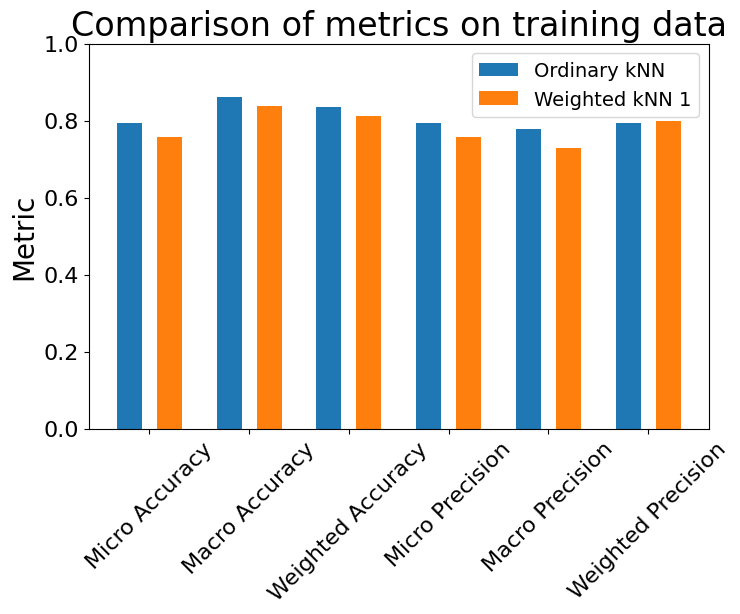

In [ ]:
bar_compare_metric(train_metrics, train_metrics_w1, ('Ordinary kNN', 'Weighted kNN 1'),training=True)

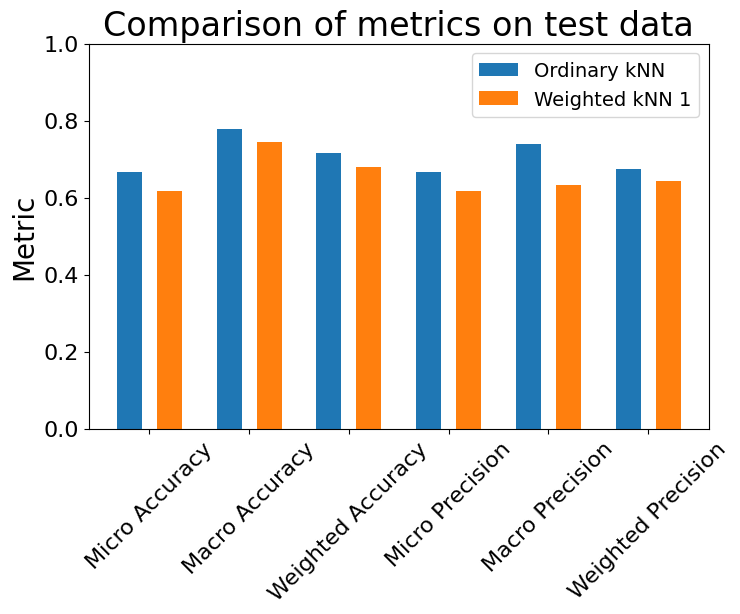

In [ ]:
bar_compare_metric(test_metrics, test_metrics_w1, ('Ordinary kNN', 'Weighted kNN 1'),training=False)

Compared to the previous unweighted kNN, one sees that the performance metrics of the weighted kNN (especially with test data) are lower. This is interpretable in terms of the minority class being already well predicted; giving to it a larger weight makes the algorithm focus even more on this class, compromising the performance on other classes, and hence the overall performance.

Instead, I will try next to implement a weighted kNN (that I call weighted kNN 2) with weights proportional to the number of data points in that class [Note: this was not asked in the coursework, it is just for the purpose of illustration].

In [ ]:
classes_train, counts_train = np.unique(y_train, return_counts=True)

## definition of weights as the number of data in training and test set
weights = counts_train
weights = weights/np.sum(weights)
for i in range(3):
  print(f'Class {classes_train[i]} weight: {weights[i]}')

Class 0 weight: 0.32413793103448274
Class 1 weight: 0.5517241379310345
Class 2 weight: 0.12413793103448276


In [ ]:
y_train_pre_w2 = predict_weighted(X_train_std, y_train, X_train_std, weights, best_k)
cw_train = counts_train/np.sum(counts_train)
train_metrics_w2 = compute_metrics(y_train, y_train_pre_w2, cw_train)
print_metrics(train_metrics_w2, training=True)

Training set:
Accuracy:
Micro Accuracy: 0.759
Macro Accuracy: 0.839
Weighted Accuracy: 0.805

Precision:
Micro Precision: 0.759
Macro Precision: 0.809
Weighted Precision: 0.787


In [ ]:
y_test_pred_w2 = predict_weighted(X_train_std, y_train, X_test_std, weights, best_k)
cw_test = counts_test/np.sum(counts_test)
test_metrics_w2 = compute_metrics(y_test, y_test_pred_w2, cw_test)
print_metrics(test_metrics_w2, training=False)

Test set:
Accuracy:
Micro Accuracy: 0.683
Macro Accuracy: 0.789
Weighted Accuracy: 0.736

Precision:
Micro Precision: 0.683
Macro Precision: 0.780
Weighted Precision: 0.710


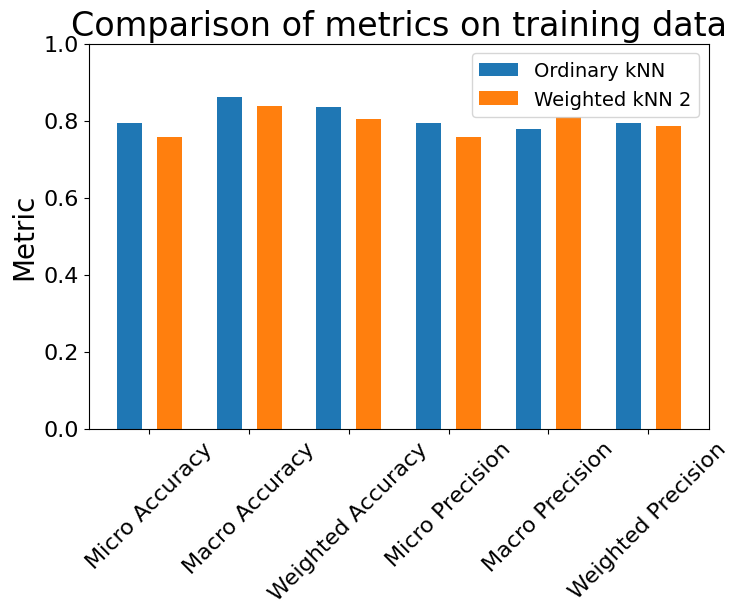

In [ ]:
bar_compare_metric(train_metrics, train_metrics_w2, ('Ordinary kNN', 'Weighted kNN 2'), training=True)

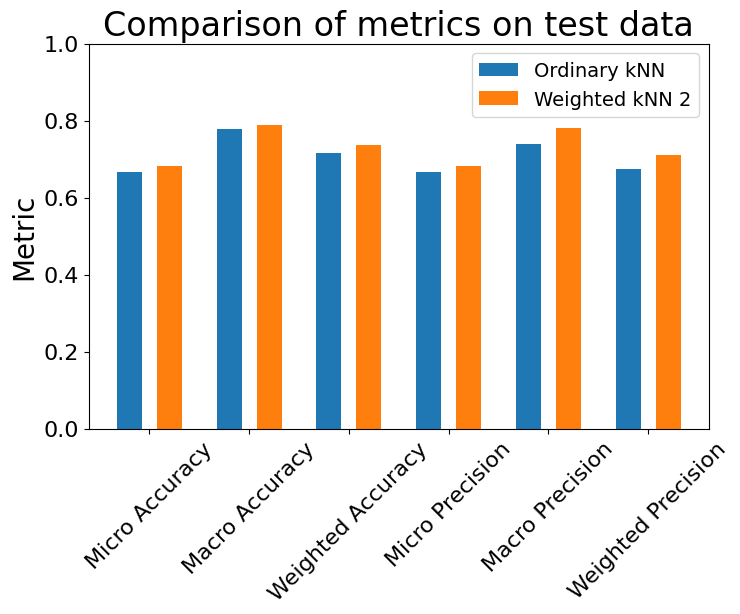

In [ ]:
bar_compare_metric(test_metrics, test_metrics_w2, ('Ordinary kNN', 'Weighted kNN 2'), training=False)

I observe that almost all test metrics of this weighted kNN 2 are generally better than those of the unweighted one, while the training ones are lower. The macro metrics are still better than the weighted metrics, indicating that the minority class is still well-predicted even when less weight is given to it. The minority class has presumably feature statistics that make it easily distinguishable from the other ones even if fewer data points are available.

<a name="task-213"></a>

### (2.1.3) [(index)](#index-task-213)

In this task, I implement a 2-step kNN, by first performing a binary classification where classes 1 and 2 are combined, and then performing another binary classification between classes 1 and 2 (for those samples that are predicted not to be class 0 in the first step). For the first step, I use the optimal k found above, for the second step I use k=1. We first combine classes 1 and 2:

In [ ]:
# 3-class classification (class 0 vs class 1&2)
y_train_b = np.array([1 if val == 2 else val for val in y_train]).astype(int)
y_test_b = np.array([1 if val == 2 else val for val in y_test]).astype(int)

In [ ]:
k = best_k
print('Training set mean accuracy:', score(X_train_std, y_train_b, X_train_std, y_train_b, k=k))
print('Test set mean accuracy:', score(X_train_std, y_train_b, X_test_std, y_test_b, k=k))

Training set mean accuracy: 0.8482758620689655
Test set mean accuracy: 0.7166666666666667


In [ ]:
y_pred_b = predict(X_train_std, y_train_b, X_test_std, k=k)

Here, the samples predicted to be class 0 (in `y_pred_b`) will have the final prediction of class 0, while those predicted to be in class 1 will need to be further splitted. In the second step, I have to use only training data with labels 1 and 2.

In [ ]:
# get training samples in classes 1 and 2
X_train_std_reduced, y_train_reduced = X_train_std[y_train!=0], y_train[y_train!=0]
# only need to predict those that are predicted to be class 1 in the first binary classification
X_test_std_reduced, y_test_reduced = X_test_std[y_pred_b!=0], y_test[y_pred_b!=0]

In [ ]:
k = 1 # as required

y_pred_reduced = predict(X_train_std_reduced, y_train_reduced, X_test_std_reduced, k=k)

For those points that are predicted to be class 1 in the first binary classification, we update their predictions thanks to the second binary classifiers. Finally I evaluate several performance metrics.

In [ ]:
y_pred_2step = y_pred_b.copy()
y_pred_2step[y_pred_b!=0] = y_pred_reduced

In [ ]:
test_metrics_2step = compute_metrics(y_test, y_pred_2step, cw_test)
print_metrics(test_metrics_2step, training=False)

Test set:
Accuracy:
Micro Accuracy: 0.683
Macro Accuracy: 0.789
Weighted Accuracy: 0.726

Precision:
Micro Precision: 0.683
Macro Precision: 0.744
Weighted Precision: 0.685


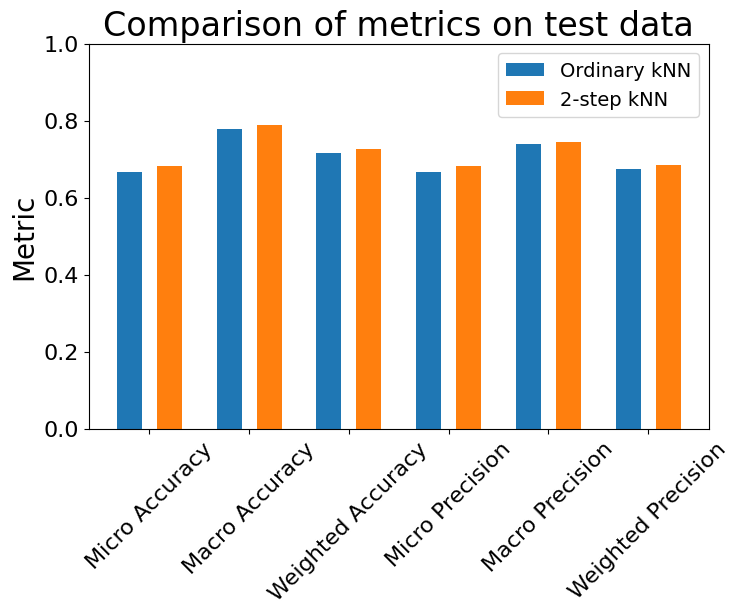

In [ ]:
bar_compare_metric(test_metrics, test_metrics_2step, ('Ordinary kNN', '2-step kNN'), training=False)

One sees that the two-step kNN performs slightly better than original kNN on test data. Although the effect is not substantial, it still indicates that class 1 and 2 are "closer together" so that they are harder to be distinguished. By implementing the 2-step kNN, we first separate out the easier class 0 data, and then focus more on the other two, leading to a better performance.



---




<a name="task-22"></a>

## (2.2) Logistic regression vs kernel logistic regression [(index)](#index-task-22)

<a name="task-221"></a>

### (2.2.1) [(index)](#index-task-221)

To perform logistic regression, I first need to define its basic building block, the logistic function.

In [ ]:
def logistic(z):
    """
    Logistic function.

    Parameters:
    z: array

    Returns:
    An array resulting from applying the logistic function elementwise to z

    """
    return 1. / (1. + np.exp(-z))

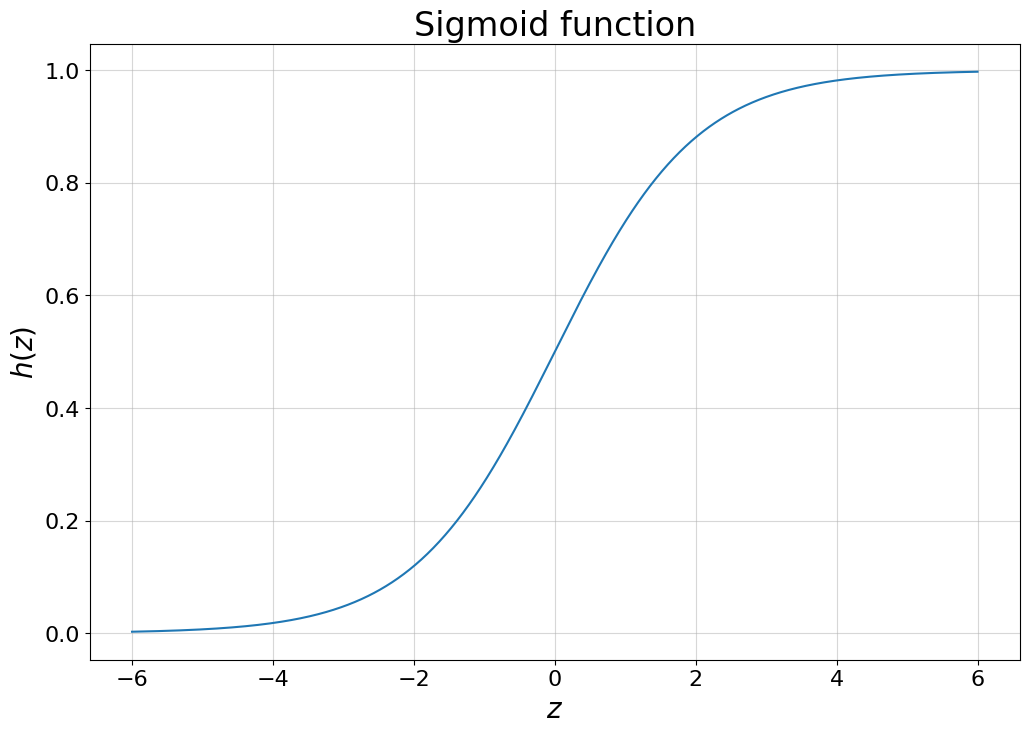

In [ ]:
plt.figure(figsize=(12,8))
z = np.linspace(-6, 6, 1000)
y = logistic(z)
plt.xlabel(r'$z$')
plt.ylabel(r'$h(z)$')
plt.title('Sigmoid function')
plt.grid(alpha=0.5)
plt.plot(z, y);

In [ ]:
# Binary classification: the last column and groupping 1s and 2s into class 1
y_train = np.array([1 if val == 2 else val for val in y_train]).astype(int)
y_test = np.array([1 if val == 2 else val for val in y_test]).astype(int)

In logistic regression, we estimate the parameter vector $\boldsymbol \beta=[\beta_1, \dots, \beta_p]^T \in \mathbb R^{p}$ and the intercept $\beta_0$ as in linear regression. However, the final step involves passing the output through a logistic function to obtain a probabilistic prediction for soft classification. We call the output of this operation $h_{\boldsymbol \beta,\beta_0}(\boldsymbol X)$:

$$
h_{\boldsymbol \beta, \beta_0}(\boldsymbol X) := h(\boldsymbol X \boldsymbol \beta+\beta_0)
$$

where $\boldsymbol X =
\begin{bmatrix}
    \vert & &\vert \\
    \boldsymbol x^{(1)} & \dots  & \boldsymbol x^{(N)}   \\
    \vert & &\vert
\end{bmatrix}^{\ T}
$ and $\boldsymbol x^{(i)} = [x_1^{(i)}, \dots, x_p^{(i)}]^T \in \mathbb R^{p}$.

$h$ is the logistic function.

One considers the negative log-likelihood loss function and minimise the associated mean sample loss, adding a penalty term that depends on the squared norm of the parameters:

$$
E(L) = - \frac{1}{N}\sum_{i=1}^N y^{(i)} \log h_{\boldsymbol \beta, \beta_0}(\boldsymbol x^{(i)}) + (1-y^{(i)}) \log (1-h_{\boldsymbol \beta, \beta_0}(\boldsymbol x^{(i)})) + \frac{\lambda}{2}{\Vert\boldsymbol\beta\Vert}^2
$$
Which has as gradient
$$
\nabla_{\boldsymbol \beta} E(L) = \frac{1}{N}\sum_{i=1}^N (h_{\boldsymbol \beta, \beta_0}(\boldsymbol x^{(i)}) - y^{(i)})\boldsymbol x^{(i)}+\lambda\boldsymbol\beta
$$$$
\nabla_{\beta_0} E(L) = \frac{1}{N}\sum_{i=1}^N (h_{\boldsymbol \beta, \beta_0}(\boldsymbol x^{(i)}) - y^{(i)})
$$

Here I report the functions from the notebook to perform prediction once the parameters are learnt:

In [ ]:
def predict_log(X, beta, beta_0):
    """
    Prediction of a probability using the logistic function.

    Parameters:
    X: Data of shape (N, p)
    beta: Parameter vector, a numpy array of size p
    beta_0: Intercept, a scalar

    Returns:
    An array containing values between 0 and 1

    """
    y_log = logistic(X @ beta + beta_0)
    return y_log.squeeze()

In [ ]:
def predict(X_test, beta, beta_0):
    """
    Arguments:
    X_test: Test set of shape (N_test, p)
    beta: Parameter vector, a numpy array of size p
    beta_0: Intercept, a scalar

    Returns:
    y_pred: Vector containing all binary predictions {0,1} for X_test

    """
    N_test = X_test.shape[0]
    y_pred = np.zeros((N_test, 1))
    beta = beta.reshape(X_test.shape[1], 1)

    # Predicting the probabilities
    y_log = predict_log(X_test, beta, beta_0)

    y_pred = y_log.round().reshape(1, -1)

    return y_pred

Here I implement the parameter learning.

A common technique in Machine Learning is to initialise the parameter vector $\boldsymbol \beta$ randomly or with zeros; we do the latter here.

In [ ]:
def initialise(size):
    """
    Argument:
    size: Size of the parameter vector beta

    Returns:
    beta: Initialised vector of shape (size, 1)

    """
    beta = np.zeros((size, 1))

    return beta

Here I modify the function `propagate` for storing loss and gradients, including the penalty term.

In [ ]:
def propagate(X, y, beta, beta_0, reg_strength):
    """
    Arguments:
    X: Data of shape (N, p)
    y: True label vector of size N
    beta: Parameter vector, a numpy array of size p
    beta_0: Intercept, a scalar
    reg_strength: A positive scalar indicating the relative weight of the regularisation term with respect to the data fidelity

    Returns:
    mean_loss: Mean sample loss for the negative log-likelihood with a regularisation term
    dbeta: Gradient of the mean sample loss with respect to beta

    """
    y_log = predict_log(X, beta, beta_0)

    # Mean sample loss function
    mean_loss = - np.mean(y * np.log(y_log) + (1-y) * np.log(1 - y_log)) + 0.5 * reg_strength * np.sum(beta**2)

    # Derivatives
    dbeta = np.mean(X.T * (y_log - y), axis=1).reshape(-1, 1) + reg_strength * beta
    dbeta_0 = np.mean(y_log - y)

    mean_loss = np.squeeze(mean_loss)

    # Store gradients in a dictionary
    grads = {'dbeta': dbeta, 'dbeta_0': dbeta_0}

    return grads, mean_loss

One can now conduct the actual parameter learning for $\boldsymbol \beta$ with a learning rate $\eta$, which is set to $0.1$. The parameter learning is performed by gradient descent, i.e. with the update rule for $\boldsymbol \beta$:

$$
\boldsymbol \beta := \boldsymbol \beta - \eta \nabla_{\boldsymbol \beta}  E(L)
$$$$
\beta_0 := \beta_0 - \eta \nabla_{\beta_0}  E(L)
$$

In [ ]:
def optimise(X, y, beta, beta_0, reg_strength=0, num_iterations=1000, learning_rate=0.1, print_loss=False):
    """
    Arguments:
    X: Data of shape (N, p)
    y: True label vector of size N
    beta: Parameter vector, a numpy array of size p
    beta_0: Intercept, a scalar
    reg_strength: A positive scalar indicating the relative weight of the regularisation term with respect to the data fidelity
    num_iterations: Number of iterations
    learning_rate: Step size in updating procedure
    print_loss: 'True' to print the mean loss every 100 iterations

    Returns:
    params: Dictionary containing the parameter vector beta
    grads: Dictionary containing the gradient
    mean_loss_history: List of all the mean loss values computed during the optimisation (can be used to plot the learning curve)

    """
    mean_loss_history = []

    for i in range(num_iterations):

        # Calculating the loss and gradients (hint: use your existing functions)
        grads, mean_loss = propagate(X, y, beta, beta_0, reg_strength)

        # Retrieving derivatives from grads
        dbeta = grads['dbeta']
        dbeta_0 = grads['dbeta_0']

        # Updating procedure
        beta = beta - learning_rate * dbeta
        beta_0 = beta_0 - learning_rate * dbeta_0

        # Record the loss values
        if i % 10 == 0:
            mean_loss_history.append(mean_loss)

        # Printing the loss every 100 iterations
        if print_loss and i % 100 == 0:
            print ('Mean loss after iteration %i: %f' %(i, mean_loss))

    # Saving parameters and gradients in dictionary
    params = {'beta': beta, 'beta_0': beta_0}
    grads = {'dbeta': dbeta, 'dbeta_0': dbeta_0}

    return params, grads, mean_loss_history

In [ ]:
def model(X_train, y_train, X_test, y_test, reg_strength=0, num_iterations=1000, learning_rate=0.1, print_loss=False):
    """
    Creates the penalised logistic regression model.

    Arguments:
    X_train: Training set of shape (N-N_test, p)
    y_train: True label vector of size N for training
    X_test: Test set of shape (N_test, p)
    y_test: True label vector of size N for test
    reg_strength: A positive scalar indicating the relative weight of the regularisation term with respect to the data fidelity
    num_iterations: Number of iterations
    learning_rate: Step size in updating procedure
    print_loss: 'True' to print the mean loss every 100 iterations

    Returns:
    d: Dictionary containing all the model information

    """
    # Initialising parameters with zeros
    beta = initialise(X_train.shape[1])
    beta_0 = 0

    # Gradient descent
    parameters, grads, mean_loss_history = optimise(X_train, y_train, beta, beta_0, reg_strength, num_iterations, learning_rate, print_loss=print_loss)

    # Retrieving parameter vector beta from dictionary 'parameters'
    beta = parameters['beta']
    beta_0 = parameters['beta_0']

    # Predicting test and training set examples
    y_pred_test = predict(X_test, beta, beta_0)
    y_pred_train = predict(X_train, beta, beta_0)

    # Printing train/test accuracy
    print('Training accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print('Test accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    # Saving all the information
    d = {'mean_loss_history': mean_loss_history, 'y_pred_test': y_pred_test, 'y_pred_train': y_pred_train, 'beta': beta, 'beta_0': beta_0, 'lambda:': reg_strength, 'learning_rate': learning_rate, 'num_iterations': num_iterations}

    return d

In [ ]:
# Running the model
d = model(X_train_std, y_train, X_test_std, y_test, reg_strength=0.0025, num_iterations=1000, learning_rate=0.1, print_loss=True)

Mean loss after iteration 0: 0.693147
Mean loss after iteration 100: 0.544315
Mean loss after iteration 200: 0.533558
Mean loss after iteration 300: 0.530230
Mean loss after iteration 400: 0.528606
Mean loss after iteration 500: 0.527568
Mean loss after iteration 600: 0.526783
Mean loss after iteration 700: 0.526133
Mean loss after iteration 800: 0.525570
Mean loss after iteration 900: 0.525072
Training accuracy: 77.93103448275862 %
Test accuracy: 81.66666666666667 %


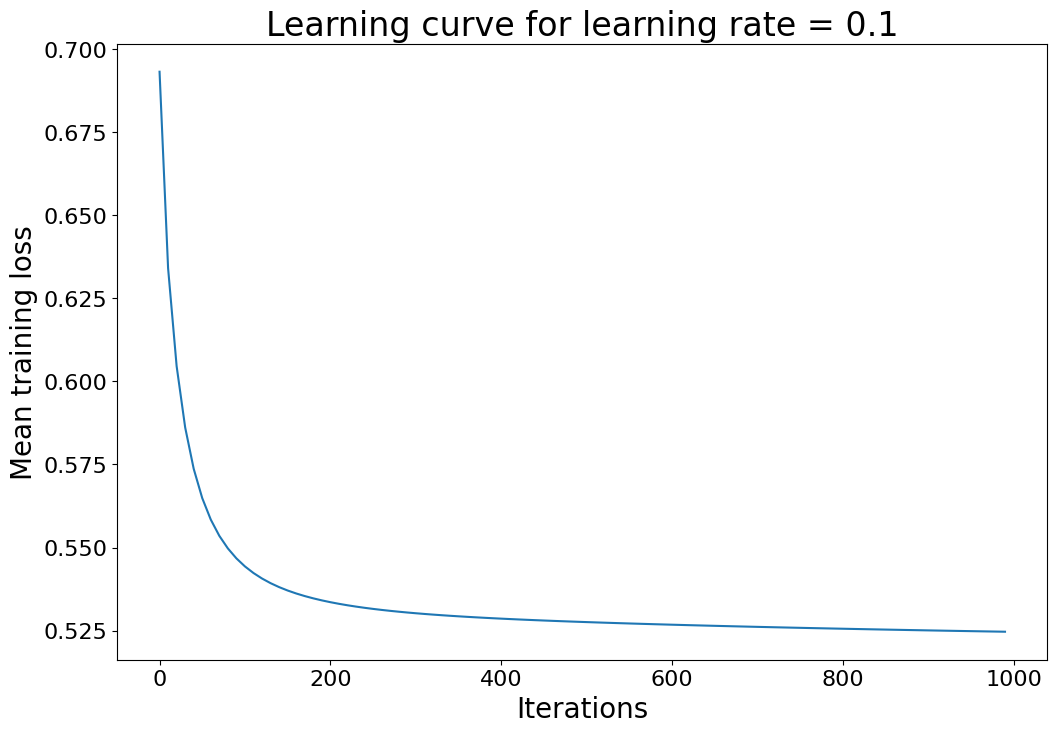

In [ ]:
loss_history = np.squeeze(d['mean_loss_history'])
plt.figure(figsize=(12,8))
plt.ylabel('Mean training loss')
plt.xlabel('Iterations')
plt.title('Learning curve for learning rate = ' + str(d['learning_rate']))
plt.plot(np.arange(0,10*len(loss_history),10), loss_history);

I run the model for 1000 iterations to assess convergence. The mean training loss decreases steadily, with a sharp decline in the initial phase and gradual stabilisation thereafter. By around 700 iterations, the loss reaches a near-constant value, indicating that further training would yield minimal improvements.

To assess the model's performance, I compute the Precision Recall Curve, and the area under the curve (AUC-PR).

In [ ]:
def precision_recall_curve(y_true, y_log):
    """
    Arguments:
    y_true: Ground truth labels with size N
    y_log: Probabilities produced by logistic regression model with size N

    Returns:
    rec_l: a list of recall values for each scanned threshold
    prec_l: a list of precision values for each scanned threshold
    thresholds: the scanned thresholds sorted descendingly
    auc_pr: area under the precision recall curve (AUC-PR)

    """
    # List of distinct values in y_log, sorted in decreasing order
    thresholds = thresholds = reversed(sorted(set(y_log)))
    rec_l, prec_l = [], []
    y_true = y_true.flatten()

    for threshold in thresholds:
        # Apply thresholding
        y_thresholded = (y_log >= threshold)
        # True positives
        tp = np.sum(y_true & y_thresholded)
        # True negatives
        tn = np.sum((~y_true) & (~y_thresholded))
        # False positives
        fp = np.sum((~y_true) & y_thresholded)
        # False negatives
        fn = np.sum(y_true & (~y_thresholded))

        # Recall
        rec = tp / (tp + fn)
        # Precision
        prec = tp / (tp + fp)

        # Appending
        rec_l.append(rec)
        prec_l.append(prec)

    # Computing AUC-PR using Trapezoidal rule
    auc_pr = np.trapz(prec_l, rec_l)

    return rec_l, prec_l, thresholds, auc_pr

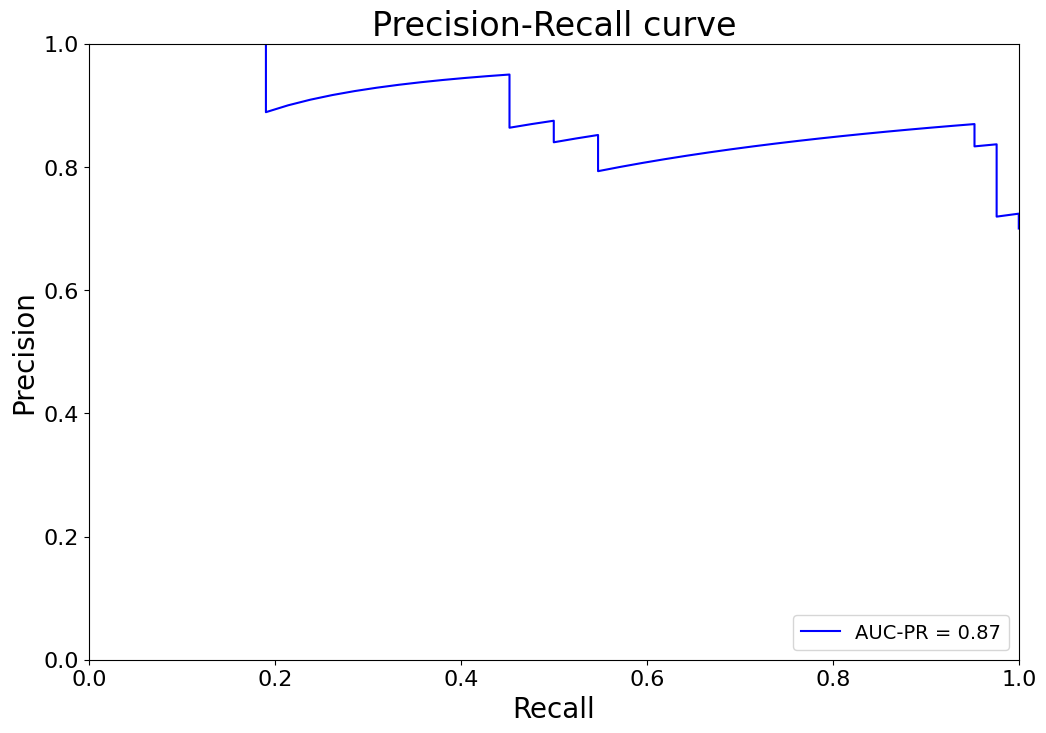

In [ ]:
y_log = predict_log(X_test_std, d['beta'], d['beta_0'])
recall_logistic, precision_logistic, thresholds, auc_pr_logistic = precision_recall_curve(y_test, y_log)

plt.figure(figsize=(12,8))
plt.title('Precision-Recall curve')
plt.plot(recall_logistic, precision_logistic, 'b', label=f'AUC-PR = {auc_pr_logistic:0.2f}')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()


<a name="task-222"></a>

### (2.2.2) [(index)](#index-task-222)

In the following, I implement a Kernel Logistic Regression with a non-linear kernel. Here, I use a Laplacian kernel:
$$k(x,y) = \text{exp}\left({-\alpha\lVert  x-y \rVert_1}\right), \;\; \alpha\gt 0$$

The mean sample loss can be written as:

$$E(L)=  - \frac{1}{N}\sum_{i=1}^N y^{(i)} \log h(\mathbf{K}^{(i)}\mathbf{u}+b) + (1-y^{(i)}) \log (1-h(\mathbf{K}^{(i)}\mathbf{u}+b)) +\frac{\lambda}{2}\mathbf{u}^{\rm{T}}\mathbf{K} \mathbf{u},$$

where $\mathbf{K}$ is the Gram matrix containing the kernel functions, *i.e*.,
 $\mathbf{K}_{ij} = k(\mathbf{x}^{(i)},\mathbf{x}^{(j)})$. Note that $\mathbf{K}^{(i)}$ represents $i^{\text{th}}$ row of matrix $\mathbf{K}$.

The gradients turn out to be:

$$
\nabla_{\mathbf{u}} E(L) = \frac{1}{N}\sum_{i=1}^N (h(\mathbf{K}^{(i)}\mathbf{u}+b) - y^{(i)})\mathbf{K}^{(i)} + \lambda\mathbf{u}^{\rm{T}}\mathbf{K}
$$

$$
\nabla_{b} E(L) = \frac{1}{N}\sum_{i=1}^N (h(\mathbf{K}^{(i)}\mathbf{u}+b) - y^{(i)})
$$

Regarding the convexity of this loss wrt $\mathbf{u}$ and the bias, the idea is to look at the Hessian and see if it is positive semidefinite everywhere:

$$
\nabla^2_{\mathbf{u}} E(L) = \lambda \mathbf{K} + \frac{1}{N}\sum_{i=1}^N \frac{\mathbf{K}^{{(i)}^T}\mathbf{K}^{(i)}}{\left(1+ e^{-(\mathbf{K}^{(i)}\mathbf{u}+b)}\right)^2}
$$

The second term is always positive semi-definite, the first is also positive semi-definite because $\lambda$ is positive and $\mathbf{K}$ is positive semi-definite. The second derivative wrt to $b$ gives just a term akin to the second term, so again it's positive.

**Another approach with classes labelled as ±1**

The loss of Kernel logistic regression can be re-written as:
$$E(L)=  \frac{1}{N}\sum_{i=1}^N \log(1+ e^{-y^{(i)}(\mathbf{K}^{(i)}\mathbf{u}+b)}) +\frac{\lambda}{2}\mathbf{u}^{\rm{T}}\mathbf{K} \mathbf{u}$$
so if I take the second derivative wrt $\mathbf{u}$ I get:
$$
\nabla^2_{\mathbf{u}} E(L) = \lambda \mathbf{K} + \frac{1}{N}\sum_{i=1}^N \frac{(y^{(i)}\mathbf{K}^{(i)})^T(y^{(i)}\mathbf{K}^{(i)})}{(1+ e^{-y^{(i)}(\mathbf{K}^{(i)}\mathbf{u}+b)})^2}
$$

First one needs a function to compute the kernel matrix, and to compute the logistic loss with the kernel.

In [ ]:
def kernel_matrix(X1, X2, alpha):
    """
    Computes the Kernel (Gram matrix) given the data

    Arguments:
    X1, X2: Pair of arrays in a lower dimensional space
    alpha: Scale parameter of the Laplacian Kernel

    Returns:
    kernel: Gram matrix

    """
    n1, m1 = X1.shape
    n2, m2 = X2.shape
    kernel = np.zeros((n1,n2))

    # Here we define a Laplacian Function Kernel
    for i in range(n1):
        exponent = np.linalg.norm(X2 - X1[i], ord=1, axis=1)
        kernel[i,:] = np.exp(-alpha * exponent)

    return kernel

In [ ]:
def compute_loss_kernel(u, bias, K, y, reg_strength=0):
    """
    Logistic regression loss with the Kernel trick

    Arguments:
    u: Parameter vector
    bias: Bias, a scalar
    K: Gram matrix
    y: True label vector of size N
    reg_strength: A positive scalar indicating the relative weight of the regularisation term with respect to the data fidelity

    Returns:
    mean_loss: Mean sample loss

    """
    y_log = predict_log(K, u, bias)
    regularisation_term = 0.5 * reg_strength * np.dot(u,K@u)
    mean_loss = - np.mean(y * np.log(y_log) + (1-y) * np.log(1 - y_log)) + regularisation_term

    return mean_loss

Here I use the gradients I have computed to perform the model's training via gradient descent.

In [ ]:
def optimise_kernel(K, y, reg_strength=0, num_iterations=1000, learning_rate=0.05, print_loss=False):
    """
    Arguments:
    K: Gram matrix
    y: True label vector of size N
    reg_strength: A positive scalar indicating the relative weight of the regularisation term with respect to the data fidelity
    num_iterations: Number of iterations
    learning_rate: Step size in updating procedure
    print_loss: 'True' to print the mean loss every 100 iterations

    Returns:
    u: Optimised parameter vector
    bias: Optimised bias
    mean_loss_history: List of all the mean loss values computed during the optimisation (can be used to plot the learning curve)

    """
    # Inisialising u and bias
    u = np.zeros(K.shape[1])
    bias = 0
    mean_loss_history = []

    for i in range(num_iterations):

        # Retrieving gradients and updating procedure
        grad_u = np.mean(K * (predict_log(K, u, bias) - y), axis=1) + reg_strength * K@u
        grad_bias = np.mean(predict_log(K, u, bias) - y)
        u = u - learning_rate * grad_u
        bias = bias - learning_rate * grad_bias

        # Record the loss values
        if i % 10 == 0:
            mean_loss = compute_loss_kernel(u, K, y, reg_strength)
            mean_loss_history.append(compute_loss_kernel(u, K, y, reg_strength))

        # Printing the loss every 100 iterations
        if print_loss and i % 100 == 0:
            print ('Mean loss after iteration %i: %f' %(i, mean_loss))

    return u, bias, mean_loss_history

<a name="task-223"></a>

### (2.2.3) [(index)](#index-task-223)

Next, I perform the training with 2 values of the kernel hyperparameter $\alpha$, I evaluate the classifier's accuracy on training and test set (with the argmax discretisation) and the Precision-Recall curve, for comparison with logistic regression without kernelisation.

In [ ]:
alpha_list = [100, 0.3]
recall_list, precision_list, auc_pr_list = [], [], []

for alpha in alpha_list:

    print('For alpha = ' + str(alpha))
    K_train = kernel_matrix(X_train_std, X_train_std, alpha)

    u, bias, mean_loss_history = optimise_kernel(K_train, y_train, reg_strength=0.0025, num_iterations=1000, learning_rate=0.1, print_loss=False)

    def score(u, bias, X, y, alpha):
        ## Defining the Kernel containing test and training data
        K_test = kernel_matrix(X, X_train_std, alpha)

        y_log = predict_log(K_test, u, bias)
        y_preds = y_log.round().reshape(1, -1)
        return np.mean(y_preds == y), y_log

    train_score, _ = score(u, bias, X_train_std, y_train, alpha)
    test_score, y_log = score(u, bias, X_test_std, y_test, alpha)

    recall, precision, _, auc_pr = precision_recall_curve(y_test, y_log)
    recall_list.append(recall)
    precision_list.append(precision)
    auc_pr_list.append(auc_pr)

    print("Training accuracy: {}".format(100*train_score))
    print("Test accuracy: {}".format(100*test_score))

For alpha = 100
Training accuracy: 68.96551724137932
Test accuracy: 70.0
For alpha = 0.3
Training accuracy: 86.20689655172413
Test accuracy: 85.0


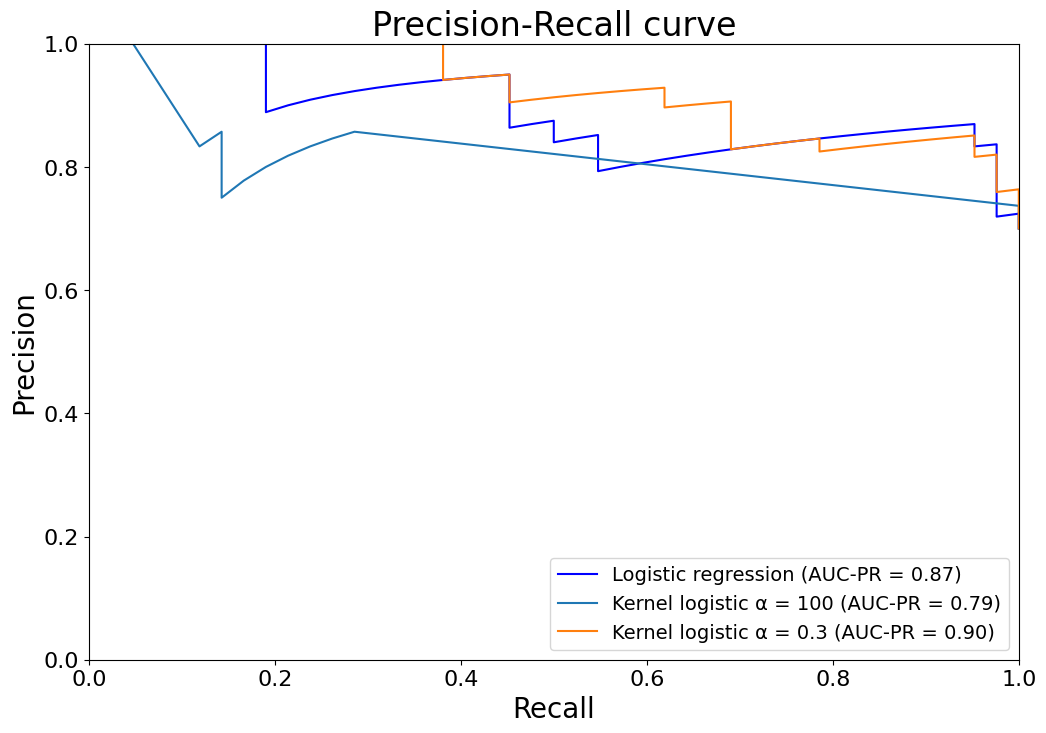

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Precision-Recall curve')
plt.plot(recall_logistic, precision_logistic, 'b', label=f'Logistic regression (AUC-PR = {auc_pr_logistic:0.2f})')
for i in range(len(alpha_list)):
    plt.plot(recall_list[i], precision_list[i], label=f'Kernel logistic α = {alpha_list[i]} (AUC-PR = {auc_pr_list[i]:0.2f})')

plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

The Precision-Recall (PR) curve suggests that kernel logistic regression with $\alpha = 0.3$ performs the best, achieving the highest AUC-PR (0.90).

The standard logistic regression, with an AUC-PR of 0.87, performs almost as well, suggesting that a simpler logistic model can be competitive even without the use of kernelisation. In contrast, kernel logistic regression with $\alpha = 100$ performs the worst, with an AUC-PR of 0.79, which highlights signs of overfitting. This model likely fits the training data too closely, leading to poorer generalisation on unseen data. Its lower precision-recall trade-off suggests that it struggles to maintain high performance across both metrics.

Overall, while a well-tuned kernel (*e.g.*, that of $\alpha = 0.3$) can enhance performance (albeit only moderately), kernelisation with too flexible hyperparameters (e.g., that of $\alpha = 100$) degrades generalisation power. Interestingly, standard logistic regression remains a strong baseline, performing comparably to the best kernelised model.